# SARIMA

### Import Libraries

In [65]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [66]:
# Options
pd.set_option("display.max_columns", None)

### Import Data

In [67]:
pp_sg = pd.read_csv("../data/preprocessing/02_pp_sg_train_features.csv", sep=";")
pp_sg_train = pp_sg[(pp_sg["datetime"] >= "2022-12-01 00:00:00") & (pp_sg["datetime"] <= "2022-12-31 23:45:00")]
pp_sg_test = pp_sg[pp_sg["datetime"] >= "2023-01-01 00:00:00"]
pp_sg_train.head()

,P24,P44,P42,P33,P23,P25,P21,P31,P53,P32,P22,P52,P51,P43,datetime,ferien,feiertag,covid_19,olma_offa,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum,date,year,month,day,weekdayname,weekday,time,hour,minute,sin_minute,cos_minute,sin_hour,cos_hour,sin_weekday,cos_weekday,sin_day,cos_day,sin_month,cos_month
41285,255.0,276.0,249.0,135.0,129.0,318.0,254.0,129.0,104.0,94.0,36.0,84.0,79.0,25.0,2022-12-01 05:13:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:13,5,13,0.978148,0.207912,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41286,250.0,274.0,247.0,122.0,128.0,309.0,250.0,128.0,102.0,92.0,36.0,84.0,77.0,26.0,2022-12-01 05:28:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:28,5,28,0.207912,-0.978148,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41287,245.0,271.0,248.0,113.0,128.0,297.0,244.0,127.0,100.0,90.0,34.0,85.0,73.0,25.0,2022-12-01 05:43:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:43,5,43,-0.978148,-0.207912,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41288,236.0,267.0,242.0,105.0,127.0,286.0,232.0,123.0,97.0,88.0,33.0,84.0,65.0,25.0,2022-12-01 05:58:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:58,5,58,-0.207912,0.978148,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41289,231.0,262.0,229.0,94.0,121.0,269.0,229.0,122.0,92.0,84.0,33.0,83.0,59.0,25.0,2022-12-01 06:13:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,06:13,6,13,0.978148,0.207912,1.000000,6.123234e-17,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0


### Plot Data

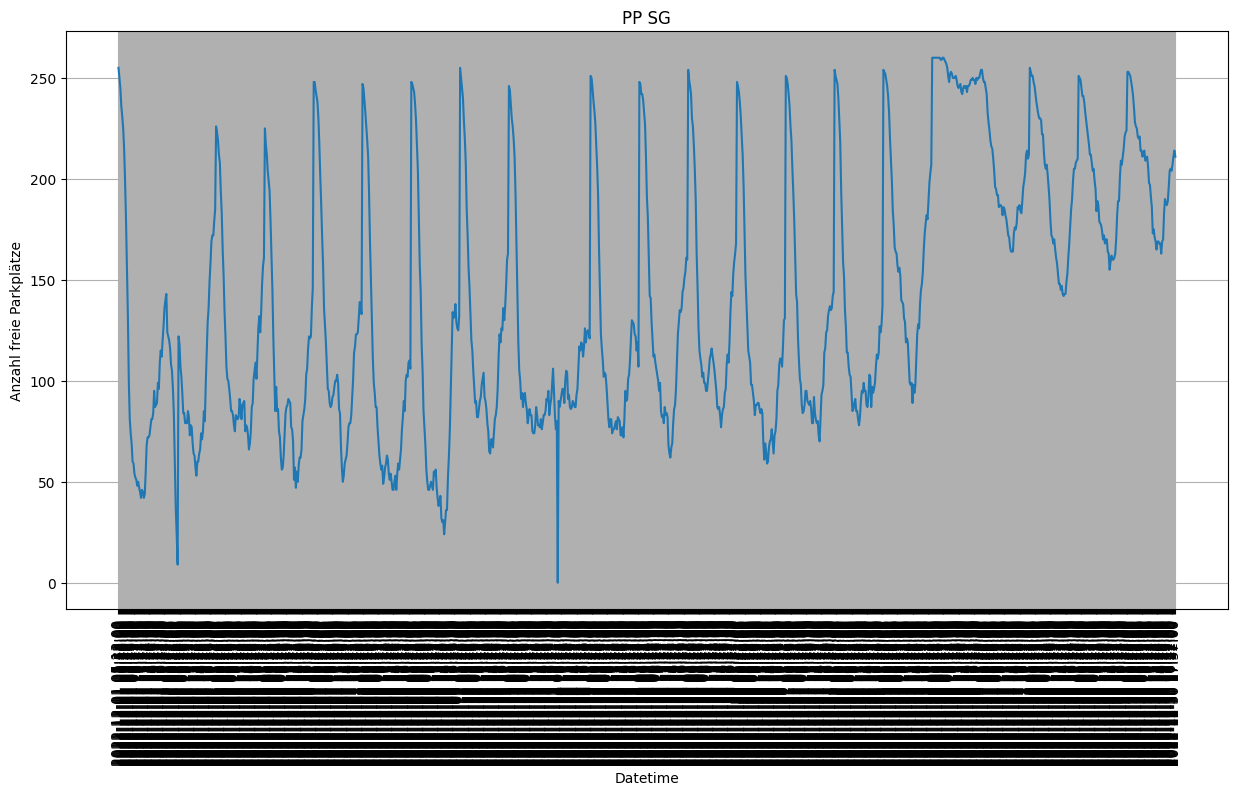

In [68]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(pp_sg_train["datetime"], pp_sg_train["P24"])
plt.title("PP SG")
plt.ylabel("Anzahl freie Parkplätze")
plt.xlabel("Datetime")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

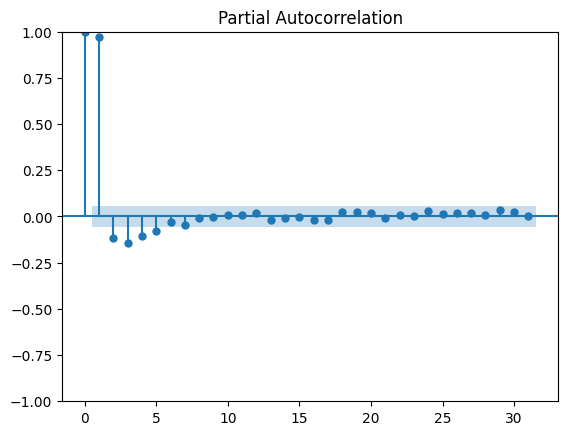

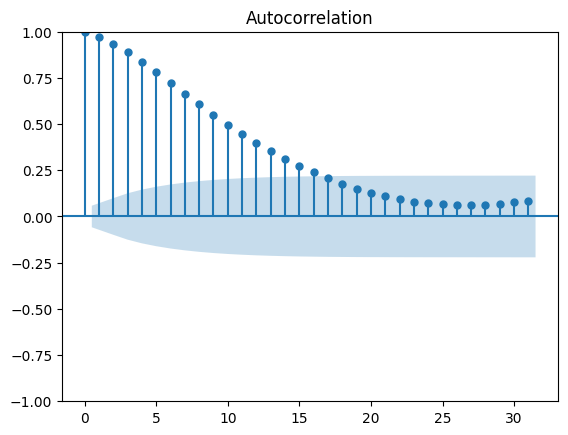

In [69]:
plot_pacf(pp_sg_train["P24"]);
plot_acf(pp_sg_train["P24"]);

In [70]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(pp_sg_train["P24"])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.231645236141699
p-value: 4.9368898208103466e-08


In [71]:
# Take the log difference to make data stationary

pp_sg_train["P24"] = np.log(pp_sg_train["P24"])
pp_sg_train["P24"] = pp_sg_train["P24"].diff()
pp_sg_train = pp_sg_train.drop(pp_sg_train.index[0])

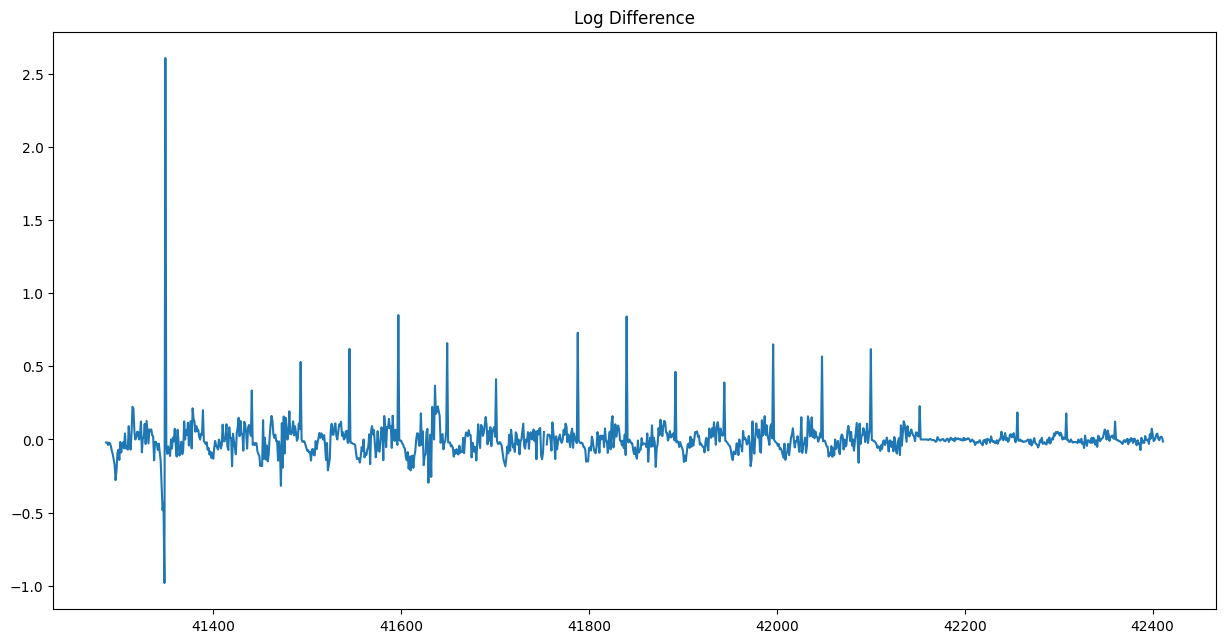

In [72]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(pp_sg_train["P24"])
plt.title("Log Difference")
plt.show()

In [73]:
pp_sg_train["P24"] = pp_sg_train["P24"].diff(96)
pp_sg_train.head()

,P24,P44,P42,P33,P23,P25,P21,P31,P53,P32,P22,P52,P51,P43,datetime,ferien,feiertag,covid_19,olma_offa,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum,date,year,month,day,weekdayname,weekday,time,hour,minute,sin_minute,cos_minute,sin_hour,cos_hour,sin_weekday,cos_weekday,sin_day,cos_day,sin_month,cos_month
41286,NaN,274.0,247.0,122.0,128.0,309.0,250.0,128.0,102.0,92.0,36.0,84.0,77.0,26.0,2022-12-01 05:28:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:28,5,28,0.207912,-0.978148,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41287,NaN,271.0,248.0,113.0,128.0,297.0,244.0,127.0,100.0,90.0,34.0,85.0,73.0,25.0,2022-12-01 05:43:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:43,5,43,-0.978148,-0.207912,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41288,NaN,267.0,242.0,105.0,127.0,286.0,232.0,123.0,97.0,88.0,33.0,84.0,65.0,25.0,2022-12-01 05:58:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,05:58,5,58,-0.207912,0.978148,0.965926,2.588190e-01,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41289,NaN,262.0,229.0,94.0,121.0,269.0,229.0,122.0,92.0,84.0,33.0,83.0,59.0,25.0,2022-12-01 06:13:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,06:13,6,13,0.978148,0.207912,1.000000,6.123234e-17,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0
41290,NaN,260.0,217.0,76.0,119.0,255.0,220.0,123.0,91.0,66.0,31.0,82.0,54.0,25.0,2022-12-01 06:25:00,0,0,0,0,2.001,1.251,1.0,0.0,2022-12-01,2022,12,1,Thursday,3,06:25,6,25,0.500000,-0.866025,1.000000,6.123234e-17,0.433884,-0.900969,0.207912,0.978148,-2.449294e-16,1.0


In [88]:
my_list = [range(1, 97, 1)] 
my_list

[range(1, 97)]

In [91]:
pp_sg_train = pp_sg_train.drop(my_list, axis=3).reset_index(drop=True)

ValueError: No axis named 3 for object type DataFrame